###  MicroGrad demo

In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [49]:
np.random.seed(1337)
random.seed(1337)

In [42]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
x_train = x_train.astype('float64') / 255.0 * 2 - 1
x_test = x_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# One-hot кодирование меток
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_oh = y_train_oh * 2 - 1
y_test_oh = y_test_oh * 2 - 1

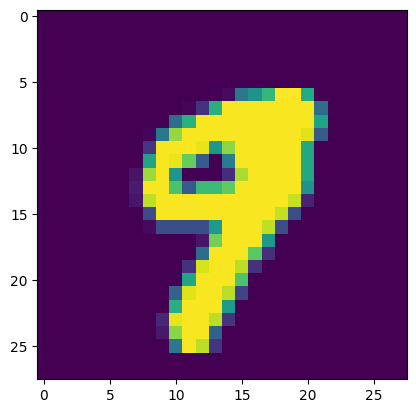

In [43]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(x_train)

In [59]:
from collections import defaultdict

POSITIVE_CLASSES = [0]

def balance(x, y, positive_classes):
    assert -1 not in positive_classes

    p_idx = np.where(np.isin(y, positive_classes))[0]
    n_idx = np.where(~np.isin(y, positive_classes))[0]
    len = min(p_idx.shape[0], n_idx.shape[0])
    p_idx = np.random.permutation(p_idx)[:len]
    n_idx = np.random.permutation(n_idx)[:len]
    idx = np.random.permutation(np.concatenate([p_idx, n_idx]))
    x, y = x[idx], y[idx]

    return x, y

X, Y = balance(x_train, y_train, POSITIVE_CLASSES)

def oh_encode(y, positive_classes):
    gray = np.array([-1] * len(positive_classes))
    oh_enc = defaultdict(lambda: gray)
    oh_dec = defaultdict(lambda: None)
    for i, cls in enumerate(positive_classes):
        cls_vec = np.array([-1.0] * len(positive_classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    return oh_dec, np.array([oh_enc[cls] for cls in y])

OH_DEC, Y_oh = oh_encode(Y, POSITIVE_CLASSES)
OH_DEC, Y_oh.shape

(defaultdict(<function __main__.oh_encode.<locals>.<lambda>()>, {(1.0,): 0}),
 (11846, 1))

In [60]:
POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

X = x_train
OH_DEC, Y_oh = oh_encode(y_train, POSITIVE_CLASSES)

In [45]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(
    784,
    [
        (10, 'tanh')
    ]
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784)], Layer of [tanh-Neuron(10)]]
number of parameters 7861


In [68]:
def batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]

    input = [list(map(Value, xi)) for xi in X]
    ground_truths = [list(map(Value, yi)) for yi in Y_oh]

    return input, ground_truths

In [69]:
# loss function
def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def decode(values):
    encoded = tuple(np.array([v.data for v in values]).round())
    return OH_DEC[encoded]


def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += decode(score) == decode(ground_truths)

    return matches / len(scores)

def loss(input, ground_truths):
    scores = list(map(model, input))
    total_loss = sum(one_loss(s, gt) for s, gt in zip(scores, ground_truths))

    return total_loss, accuracy(scores, ground_truths)

total_loss, acc = loss(*batch(X, Y_oh, 64))
total_loss.data, acc

(28.0, 0.0)

In [71]:
BATCH_SIZE = 64
BATCH = batch(X, Y_oh, BATCH_SIZE)

# optimization
for k in range(1):

    # forward
    total_loss, acc = loss(*BATCH)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        #p.data += -learning_rate * p.grad
        p.learn(0.5)

total_loss, acc = loss(*BATCH)
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 32.0, accuracy 0.0%
final loss 32.0, accuracy 0.0%


In [72]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.grad)
parameters

[Value(data=0.851070800952636, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.4197599510563062, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.1419579489234582, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.4637896458495146, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.5503992427380338, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=-0.3344213592120892, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.26974783676637376, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=-0.28030928933676397, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.9912909479419789, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=-0.216897322319701, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.3942398176667386, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.5230726116674183, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(data=0.7276601346513822, pgrad=0.0, grad=0.0, lr=294137134.7742978),
 Value(da